In [1]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [2]:
K._get_available_gpus()

['/device:GPU:0', '/device:GPU:1']

In [3]:
input_size = (224, 224)
dataset_directory = 'data/training_set'

images = []
labels = []

for class_name in os.listdir(dataset_directory):
    class_directory = os.path.join(dataset_directory, class_name)
    
    if os.path.isdir(class_directory):
        for image_filename in os.listdir(class_directory):
            image_path = os.path.join(class_directory, image_filename)
            
            image = cv2.imread(image_path)
            
            if image is not None:
                image = cv2.resize(image, input_size)
                images.append(image)
                labels.append(class_name)

xtrain = np.array(images)
ytrain = np.array(labels)

print("Shape of images array:", xtrain.shape)
print("Shape of labels array:", ytrain.shape)


Shape of images array: (8005, 224, 224, 3)
Shape of labels array: (8005,)


In [4]:
input_size = (224, 224)
dataset_directory = 'data/test_set'

images = []
labels = []

for class_name in os.listdir(dataset_directory):
    class_directory = os.path.join(dataset_directory, class_name)
    
    if os.path.isdir(class_directory):
        for image_filename in os.listdir(class_directory):
            image_path = os.path.join(class_directory, image_filename)
            
            image = cv2.imread(image_path)
            
            if image is not None:
                image = cv2.resize(image, input_size)
                images.append(image)
                labels.append(class_name)

xtest = np.array(images)
ytest = np.array(labels)

print("Shape of images array:", xtest.shape)
print("Shape of labels array:", ytest.shape)


Shape of images array: (2023, 224, 224, 3)
Shape of labels array: (2023,)


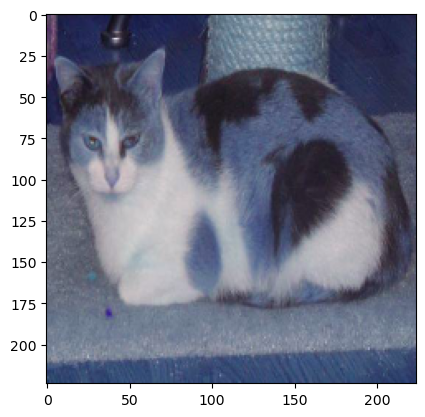

In [5]:
import matplotlib.pyplot as plt
plt.imshow(xtrain[100])

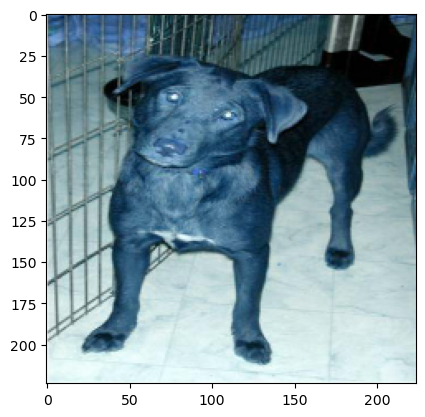

In [6]:
plt.imshow(xtrain[4000])

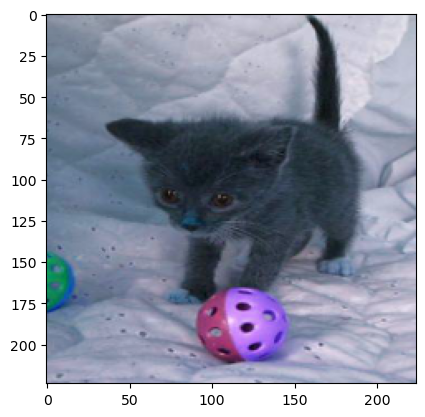

In [7]:
plt.imshow(xtest[100])

In [8]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [9]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [10]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [11]:
base_model = ResNet50(input_shape=(224, 224, 3))

In [12]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [13]:
model = Model(inputs=base_model.input, outputs=headModel)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [14]:
base_model.load_weights("resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [15]:
for layer in base_model.layers:
    layer.trainable = False

In [16]:
for layer in model.layers:
    print(f"{layer}: {layer.trainable}\n")

<keras.engine.input_layer.InputLayer object at 0x000001AFDA1F0520>: False

<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000001AFDA30C8E0>: False

<keras.layers.convolutional.conv2d.Conv2D object at 0x000001AFDA30C850>: False

<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001AF46D34130>: False

<keras.layers.core.activation.Activation object at 0x000001AFDA3A3310>: False

<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001AFDA3F0A60>: False

<keras.layers.convolutional.conv2d.Conv2D object at 0x000001AFDA655490>: False

<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001AFDA655790>: False

<keras.layers.core.activation.Activation object at 0x000001AFDA655730>: False

<keras.layers.convolutional.conv2d.Conv2D object at 0x000001AFDA662A90>: False

<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001AFDA669CD0>: False

<keras.layers.core.activation.Acti

In [17]:
opt = SGD(learning_rate=1e-3, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [18]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [19]:
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy')

In [20]:
ytrain

array(['cats', 'cats', 'cats', ..., 'dogs', 'dogs', 'dogs'], dtype='<U4')

In [21]:
ytest

array(['cats', 'cats', 'cats', ..., 'dogs', 'dogs', 'dogs'], dtype='<U4')

In [22]:
from sklearn.preprocessing import LabelBinarizer
l = LabelBinarizer()
ytrain = l.fit_transform(ytrain)
ytest = l.transform(ytest)

In [23]:
ytrain

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [24]:
ytest

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [25]:
H = model.fit(xtrain,ytrain,epochs=100,verbose=1,callbacks=[mc,es])

Epoch 1/100
251/251 [==============================] - 35s 113ms/step - loss: 0.0765 - accuracy: 0.9696
Epoch 2/100
251/251 [==============================] - 28s 111ms/step - loss: 0.0118 - accuracy: 0.9960
Epoch 3/100
251/251 [==============================] - 28s 112ms/step - loss: 0.0025 - accuracy: 0.9998
Epoch 4/100
251/251 [==============================] - 28s 111ms/step - loss: 9.4019e-04 - accuracy: 1.0000
Epoch 5/100
251/251 [==============================] - 28s 112ms/step - loss: 6.2629e-04 - accuracy: 1.0000
Epoch 6/100
251/251 [==============================] - 29s 115ms/step - loss: 4.7444e-04 - accuracy: 1.0000
Epoch 7/100
251/251 [==============================] - 28s 113ms/step - loss: 3.8623e-04 - accuracy: 1.0000
Epoch 8/100
251/251 [==============================] - 30s 121ms/step - loss: 3.2611e-04 - accuracy: 1.0000
Epoch 9/100
251/251 [==============================] - 29s 116ms/step - loss: 2.8219e-04 - accuracy: 1.0000
Epoch 10/100
251/251 [==================

In [26]:
ypreds = model.predict(xtest)

64/64 [==============================] - 10s 114ms/step


In [28]:
ytest

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

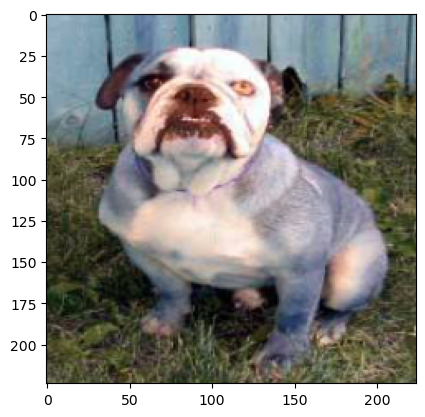

In [44]:
plt.imshow(xtest[2000])

In [38]:
ypreds

array([[2.8477031e-11],
       [5.7627749e-06],
       [8.1294284e-11],
       ...,
       [9.9979520e-01],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [39]:
ypreds[ypreds > 0.5] = 1
ypreds[ypreds <= 0.5] = 0

In [40]:
ypreds

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [45]:
ypreds[2000]

array([1.], dtype=float32)

In [41]:
from sklearn.metrics import accuracy_score

In [42]:
accuracy_score(ytest,ypreds)

0.9817103311913